#### Import needed libraries

In [28]:
import pandas as pd
from pathlib import Path
from collections import defaultdict
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN, KMeans
from sklearn.mixture import GaussianMixture


#### 1. Choose the protein

In [5]:
PROTEIN = "HNRNPC"
# PROTEIN = "HNRNPA2B1"

# Directiories to load data
PROTEIN_FOLDER = Path(f"./{PROTEIN}")
EXPECTED_PATTERN_FILE = PROTEIN_FOLDER / f"{PROTEIN}_expected_pattern.txt"
PATTERN_CANDIDATES_FOLDER = PROTEIN_FOLDER / f"{PROTEIN}_binding_sites_fshape"
PATTERN_SEARCH_FOLDER = PROTEIN_FOLDER / f"{PROTEIN}_hnrnpc_search_fshape"

#### 2. Check the expected pattern and its length

In [6]:
expected_pattern_df = pd.read_csv(EXPECTED_PATTERN_FILE, sep="\t", header=None, names=["fSHAPE", "base"])
pattern_size = expected_pattern_df.shape[0]
print("Expected pattern size:", pattern_size)
expected_pattern_df

Expected pattern size: 6


,fSHAPE,base
0,0.00,N
1,1.25,T
2,1.15,T
3,3.00,T
4,1.70,T
5,0.10,N


#### 3. Define lengths of promising patterns

In [7]:
pattern_lengths = [pattern_size, pattern_size + 1, pattern_size + 2]

#### 4. Extract all promising, continuous patterns of lengths w = len ... len + 2 without NaNs and with at least one nucleotide with fSHAPE > 1.0

In [21]:
def is_promising(pattern):
    if pattern.isnull().values.any():
        return False
    return (pattern > 1.0).any()

In [23]:
patterns = defaultdict(list)
fshapes = defaultdict(list)

for candidate_file in PATTERN_CANDIDATES_FOLDER.glob("*"):
    candidates_df = pd.read_csv(candidate_file, sep="\t", header=None, names=["fSHAPE", "base", "SHAPE"])
    for pattern_length in pattern_lengths:
        promising_patterns = candidates_df["fSHAPE"].rolling(pattern_length).apply(is_promising)
        # print(promising_patterns)
        for i in range(candidates_df.shape[0]):
            if promising_patterns[i] == 1:
                patterns[pattern_length].append(candidates_df["base"][i - pattern_length + 1 : i + 1].to_numpy())
                fshapes[pattern_length].append(candidates_df["fSHAPE"][i - pattern_length + 1 : i + 1].to_numpy())

print(f"Found {sum([len(x) for x in patterns.values()])} patterns")

example_pattern_length = pattern_lengths[1]
print(f'example pattern of length {example_pattern_length}:')
print(patterns[example_pattern_length][0])
print(fshapes[example_pattern_length][0])

Found 2140 patterns
example pattern of length 7:
['C' 'A' 'C' 'C' 'T' 'A' 'A']
[-0.0073148   0.6515937   0.24909604  0.12207691  0.27174267  0.59119743
  1.78560917]


#### 5. Clustering analysis with use of KMEANS++, DBSCAN, GaussianMixture

In [26]:
def plot_pca_clusters(data, labels, ax, algorithm):
    targets = np.unique(labels)
    pca = PCA(n_components=2)
    embeddings = pca.fit_transform(data)
    for target in targets:
        ax.scatter(embeddings[labels == target, 0], embeddings[labels == target, 1], s=50, alpha=0.5, edgecolors='none')

    ax.set_title(algorithm)
    ax.set_xlabel("Component 1")
    ax.set_ylabel("Component 2")
    ax.set_xscale('log')
    print(f"Explained variance of {algorithm}: {pca.explained_variance_ratio_}")


Length Number: 6
Explained variance of KMeans: [0.85918968 0.04786084]
Explained variance of DBSCAN: [0.85918968 0.04786084]
Explained variance of GaussianMixture: [0.85918968 0.04786084]
Length Number: 7


c:\Users\micha\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\micha\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Explained variance of KMeans: [0.9184672  0.02415631]
Explained variance of DBSCAN: [0.9184672  0.02415631]
Explained variance of GaussianMixture: [0.9184672  0.02415631]
Length Number: 8


c:\Users\micha\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Explained variance of KMeans: [0.86462297 0.08159485]
Explained variance of DBSCAN: [0.86462297 0.08159485]
Explained variance of GaussianMixture: [0.86462297 0.08159485]


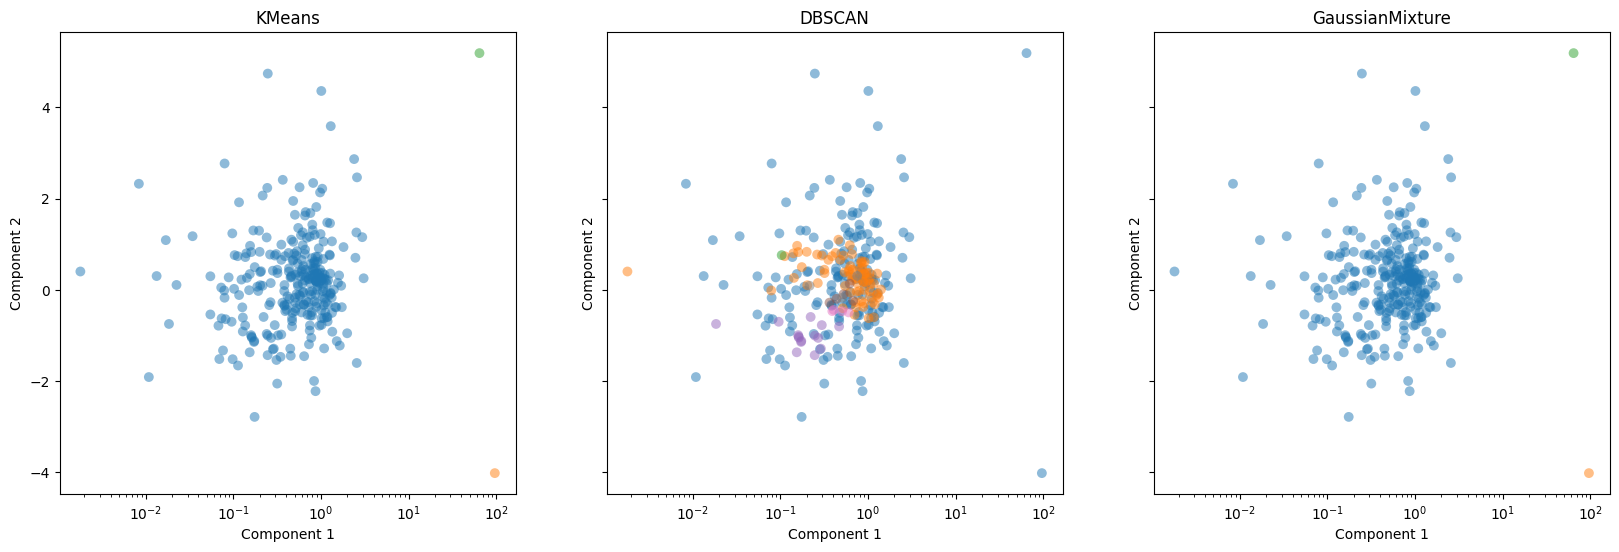

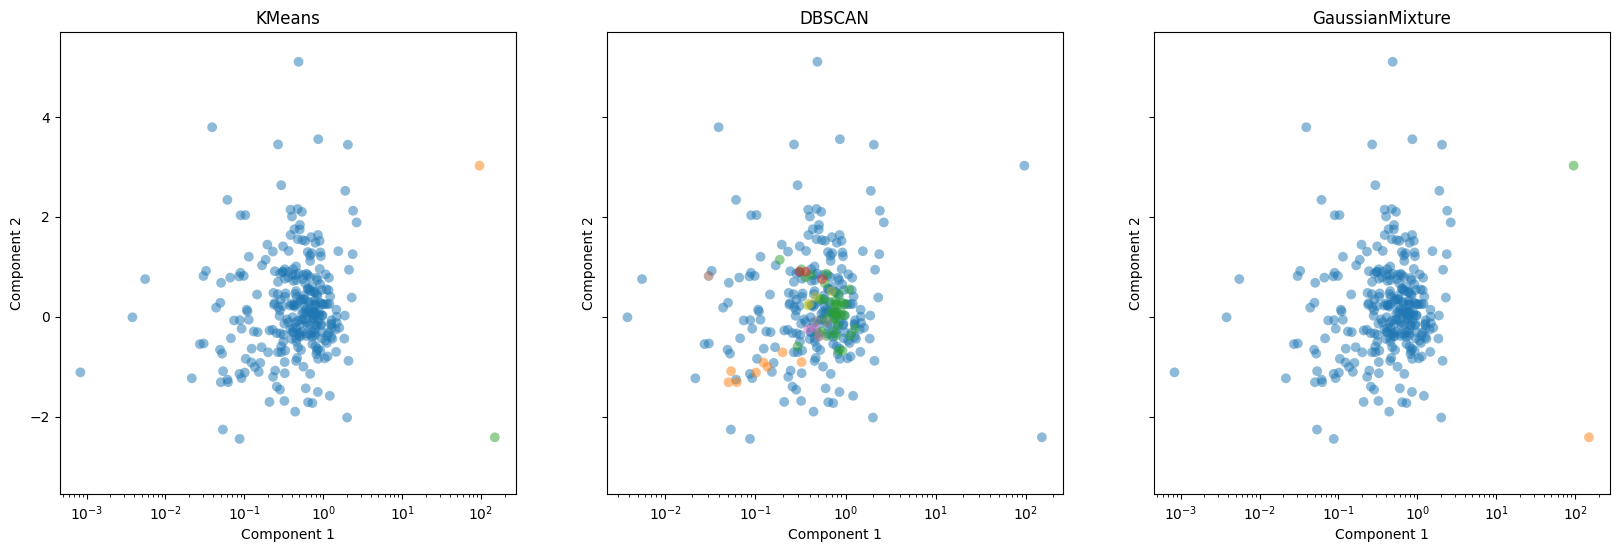

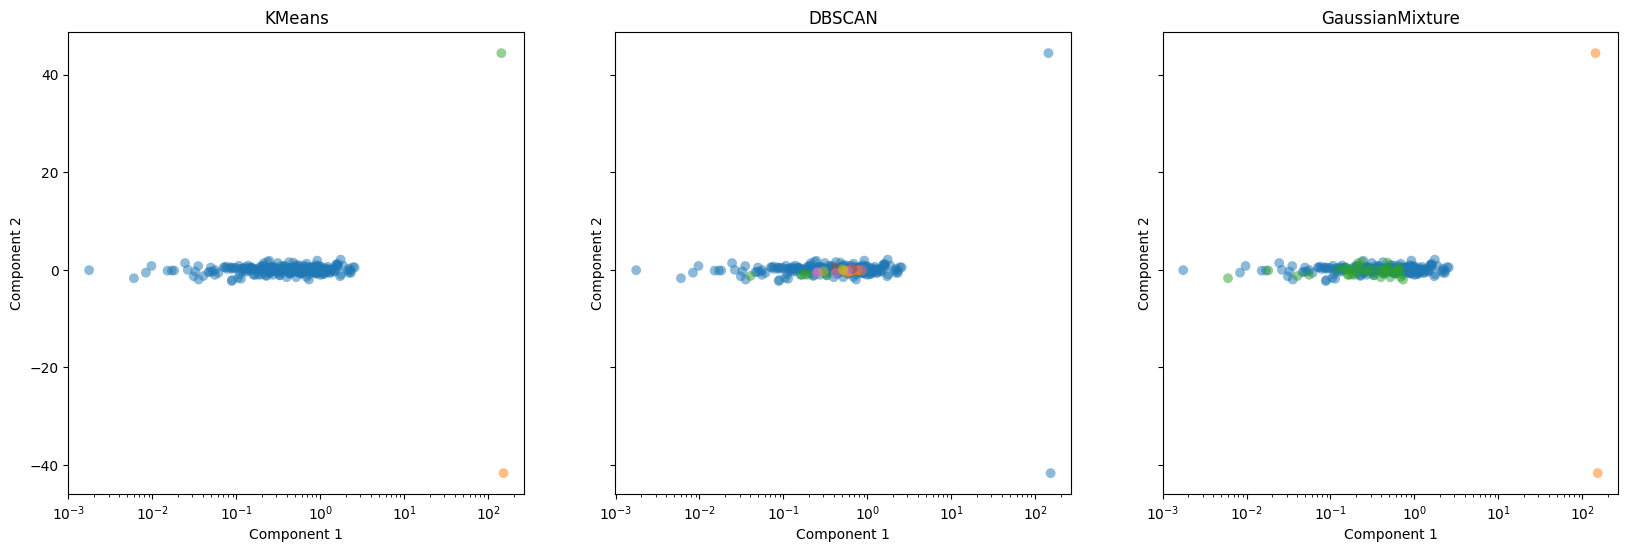

In [33]:
for length in pattern_lengths:
    print('Length Number:', length)
    curr_fshapes = fshapes[length]
    fig, (ax1, ax2, ax3) = plt.subplots(figsize=(20, 6), ncols=3, sharey=True)
    y_pred = KMeans(n_clusters=3).fit_predict(curr_fshapes)
    plot_pca_clusters(curr_fshapes, y_pred, ax1, 'KMeans')
    y_pred = DBSCAN(eps=0.6, min_samples=3).fit_predict(curr_fshapes)
    # y_pred = clustering.labels_.astype(int)
    plot_pca_clusters(curr_fshapes, y_pred, ax2, 'DBSCAN')
    y_pred = GaussianMixture(n_components=3).fit_predict(curr_fshapes)
    plot_pca_clusters(curr_fshapes, y_pred, ax3, 'GaussianMixture')
plt.show()